# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder


## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**( 2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        z = np.dot(X, weights)
        return 1 / (1 + np.exp(-z))

    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        loss = np.mean(np.log(1 + np.exp(-np.dot(x,weights)*y)) + (1 / (2 * self.C)) * np.linalg.norm(self.weights_)**2)
        return loss

     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            #delta = "<your code>"
            delta = -(X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y))))) / len(y) + self.weights_ 
            self.weights_ -= self.eta * delta
            #if "<your code>":
            self.loss.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        result = []
        for i in self.predict_proba(X):
            if i <0.5:
                result.append(-1)
            else:
                result.append(1)
        return result


In [5]:
from sklearn import datasets
from sklearn import metrics

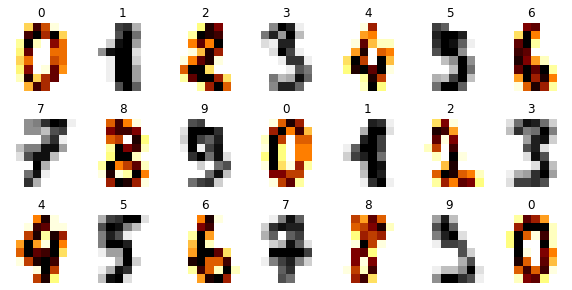

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

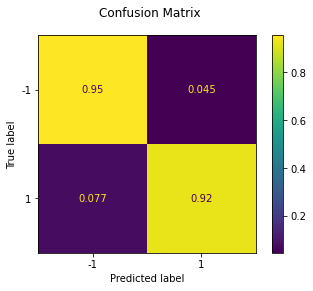

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0, 0.5, 'Loss value')

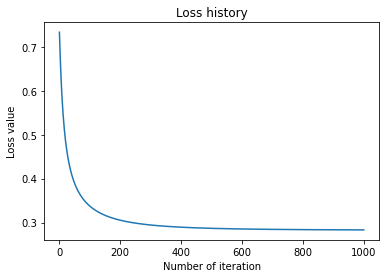

In [17]:
## your code
sns.lineplot(x=np.linspace(1, len(model.loss),len(model.loss)),y=model.loss)
plt.title('Loss history')
plt.xlabel('Number of iteration')
plt.ylabel('Loss value')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [18]:
## your code
list_eta = []
eta = [0.001,0.005,0.01,0.05,0.1]

for x  in eta:
    model = CustomLogisticRegression(eta=x)
    model.fit(X_train, y_train)
    list_eta.append(model.loss)

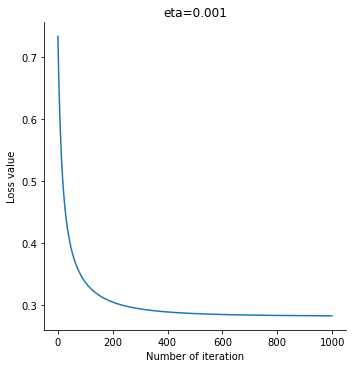

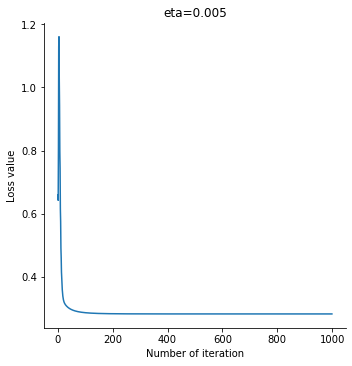

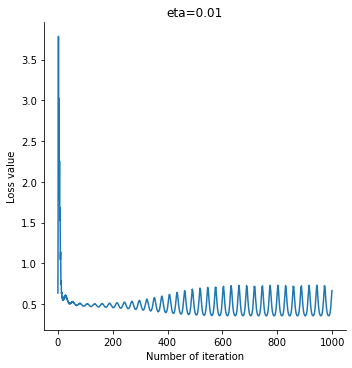

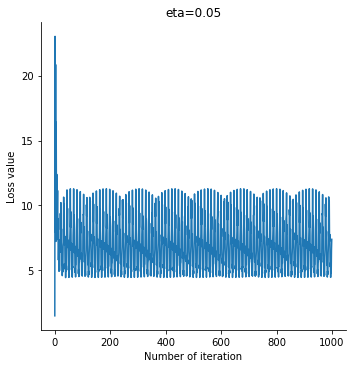

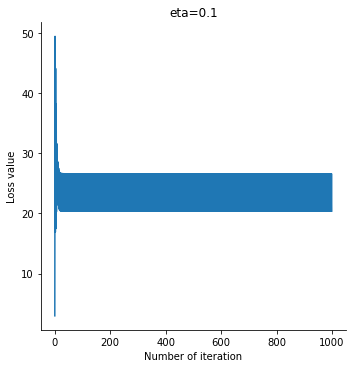

In [19]:
for x in range(len(list_eta)):
    sns.relplot(x=np.arange(len(list_eta[x])),y=list_eta[x],kind='line')
    plt.title(f'eta={eta[x]}')
    plt.xlabel('Number of iteration')
    plt.ylabel('Loss value')

< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

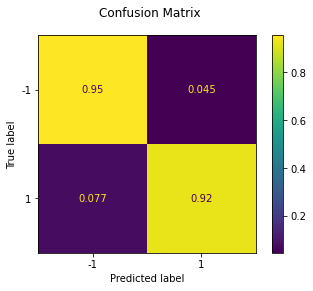

In [20]:
## your code
model = CustomLogisticRegression(C = 0.01)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

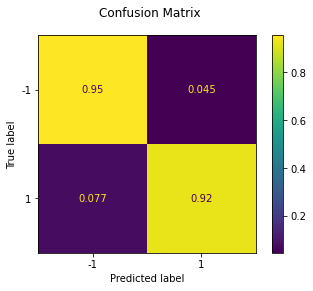

In [21]:
model = CustomLogisticRegression(C = 0.5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

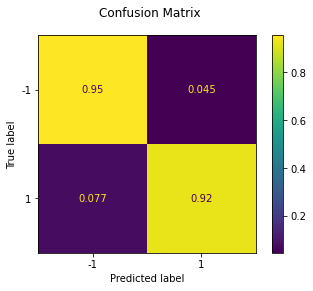

(0.9109255393180237, 0.9388888888888889)

In [22]:
model= CustomLogisticRegression(C=1.0)
fit_evaluate(model, X_train, y_train, X_test, y_test)

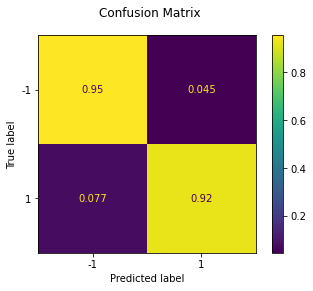

(0.9109255393180237, 0.9388888888888889)

In [23]:
model= CustomLogisticRegression(C=2.0)
fit_evaluate(model, X_train, y_train, X_test, y_test)

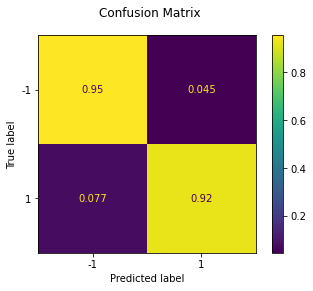

In [24]:
model = CustomLogisticRegression(C = 100)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

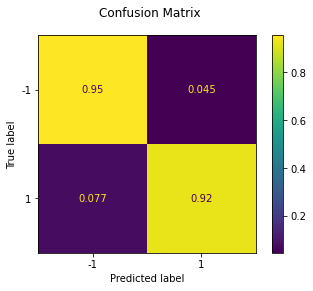

(0.9109255393180237, 0.9388888888888889)

In [25]:
## your code
model= CustomLogisticRegression(zero_init=False)
fit_evaluate(model, X_train, y_train, X_test, y_test)

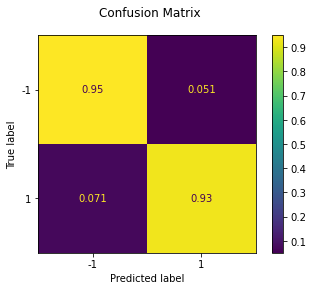

(0.9116214335421016, 0.9388888888888889)

In [26]:
model= CustomLogisticRegression(zero_init=True)
fit_evaluate(model, X_train, y_train, X_test, y_test)

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [27]:
PATH = "C:\\data\\"

In [28]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [29]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Количество мужчин и женщин ехало на корабле
male      56114
female    43886
Name: Sex, dtype: int64


<AxesSubplot:xlabel='Sex', ylabel='Counts for Sex'>

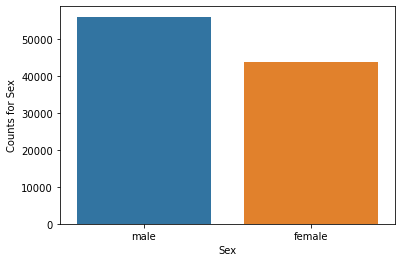

In [30]:
print('Количество мужчин и женщин ехало на корабле')
print(data.Sex.value_counts())

dt_value_counts = pd.DataFrame(data['Sex'].value_counts())
dt_value_counts = dt_value_counts.reset_index()
dt_value_counts.columns = ['Sex', 'Counts for Sex']
sns.barplot(x='Sex', y='Counts for Sex', data = dt_value_counts)

Доля выживших пассажиров
          Pclass   Name    Sex    Age  SibSp  Parch  Ticket   Fare  Cabin  \
Survived                                                                    
0          57226  57226  57226  55290  57226  57226   55016  57153  12577   
1          42774  42774  42774  41418  42774  42774   40361  42713  19557   

          Embarked  
Survived            
0            57098  
1            42652  
42.77 %


<AxesSubplot:xlabel='Survived', ylabel='Counts for Survived'>

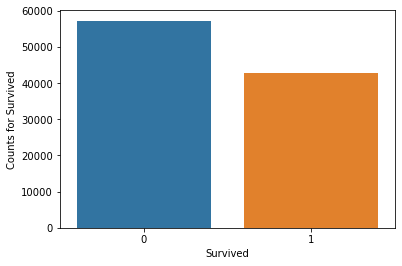

In [31]:
print('Доля выживших пассажиров')
mask = data['Survived'] == 1
newdata=data[mask]

print(data.groupby('Survived').count())
                                        
onePercentTotal=data.Survived.count()/100
survived=data.Survived.sum()

print(round(survived/onePercentTotal,2),'%')


dt_value_counts = pd.DataFrame(data['Survived'].value_counts())
dt_value_counts = dt_value_counts.reset_index()
dt_value_counts.columns = ['Survived', 'Counts for Survived']
sns.barplot(x='Survived', y='Counts for Survived', data = dt_value_counts)

Text(0.5, 1.0, 'Соотношение выживших от пола')

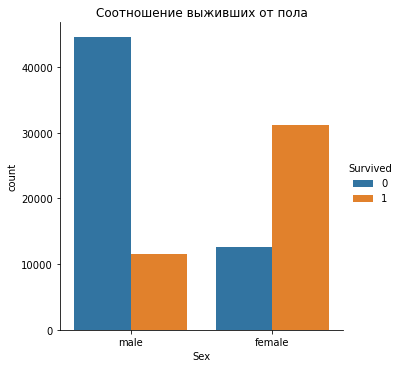

In [32]:
sns.catplot(x='Sex', data=data, hue='Survived', kind='count')
plt.title("Соотношение выживших от пола")

How we can see from calculations and plots it's has the addiction between survived and sex:
•	56114 males and 43886 females, 57226 died and 42774 survived;
•	survived passengers: total 42.77 %;
•	survival rate for females was higher.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(0.5, 1.0, 'Соотношение пассажиров по возрасту')

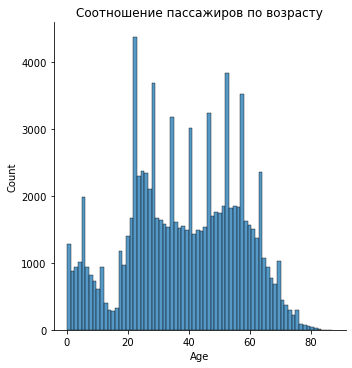

In [33]:
sns.displot(data['Age'])
plt.title("Соотношение пассажиров по возрасту")

<AxesSubplot:>

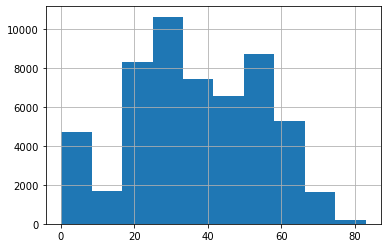

In [34]:
data[data['Survived'] == 0]['Age'].hist()

<AxesSubplot:>

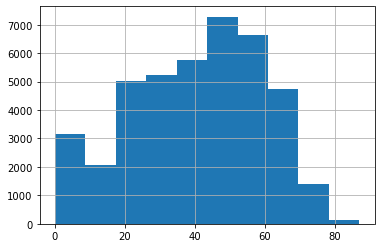

In [35]:
data[data['Survived'] == 1]['Age'].hist()

In [36]:
total = round(data['Age'].mean(),2)
total_median = data['Age'].median()
dead = round(data[data['Survived'] == 0]['Age'].mean(),2)
dead_median = round(data[data['Survived'] == 0]['Age'].median(),2)
survived = round(data[data['Survived'] == 1]['Age'].mean(),2)
survived_median= round(data[data['Survived'] == 1]['Age'].median(),2)
print(f'total: {total}')
print(f'total_median: {total_median}')
print(f'dead: {dead}')
print(f'dead_median: {dead_median}')
print(f'survived: {survived}')
print(f'survived_median: {survived_median}')

total: 38.36
total_median: 39.0
dead: 36.71
dead_median: 36.0
survived: 40.55
survived_median: 43.0


How we can see from calculation average and the median age are different.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0.5, 1.0, 'Соотношение пассажиров по классу обслуживания')

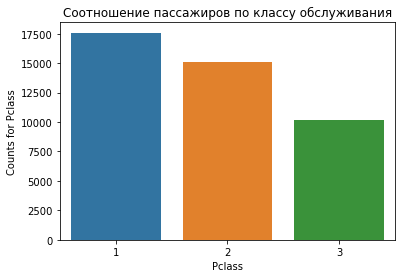

In [37]:
dt_value_counts = pd.DataFrame(data[data['Survived'] == 1]['Pclass'].value_counts())
dt_value_counts = dt_value_counts.reset_index()
dt_value_counts.columns = ['Pclass', 'Сounts for Pclass']
sns.barplot(x='Pclass', y='Сounts for Pclass',   data = dt_value_counts)
plt.title('Соотношение пассажиров по классу обслуживания')

Text(0.5, 1.0, 'Соотношение пассажиров по пункту отправления')

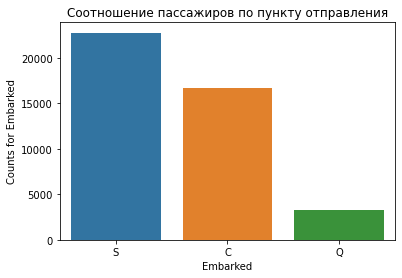

In [38]:
dt_value_counts = pd.DataFrame(data[data['Survived'] == 1]['Embarked'].value_counts())
dt_value_counts = dt_value_counts.reset_index()
dt_value_counts.columns = ['Embarked', 'Сounts for Embarked']
sns.barplot(x='Embarked', y='Сounts for Embarked',   data = dt_value_counts)
plt.title('Соотношение пассажиров по пункту отправления')

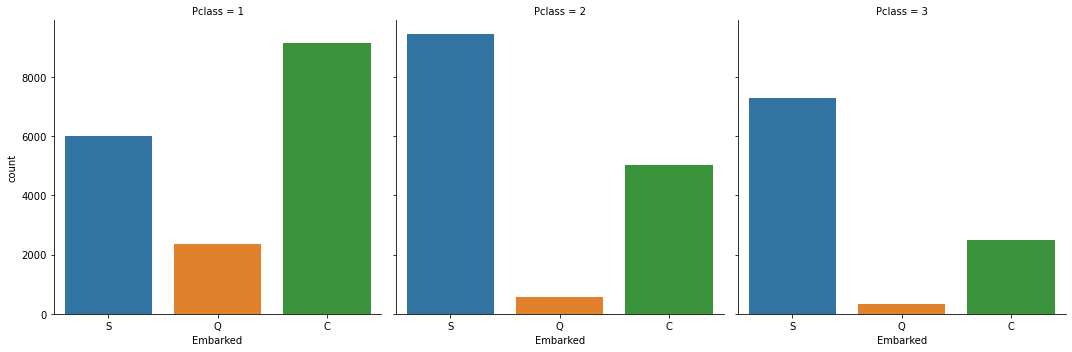

In [39]:
sns.catplot(x='Embarked', col='Pclass', data=pd.DataFrame(data[data['Survived'] == 1]), kind='count')

The safest class is the first, slightly less secure the second. More people survived who boarded a ship in Southampton, with first and second class people from the number of survivors, not much more boarded there than in the port of Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [40]:
data.isna().mean()

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Age 3,29%, Ticket 4.62%, Fare 0.13%, Cabin 67.87%, Embarked 0.25%
Missed values of ages and coast we can fill average and median. We can not use numbers of cabines in forecast and calculations.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [42]:
data['Sex'] = data['Sex'].apply(lambda x: 0 if x=='male' else 1)
data['Embarked']=data['Embarked'].apply(lambda x: 0 if x=='S' else 1 if x=='C' else 2)
data.Age=data.Age.fillna(data.Age.mean())
data.drop(columns='Cabin', inplace=True)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
0,1,1,"Oconnor, Frankie",0,38.355472,2,0,209245,27.14,0
1,0,3,"Bryan, Drew",0,38.355472,0,0,27323,13.35,0
2,0,3,"Owens, Kenneth",0,0.330000,1,2,CA 457703,71.29,0
3,0,3,"Kramer, James",0,19.000000,0,0,A. 10866,13.04,0
4,1,3,"Bond, Michael",0,25.000000,0,0,427635,7.76,0
...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",1,62.000000,0,0,PC 15008,14.86,1
99996,0,2,"Brown, Herman",0,66.000000,0,0,13273,11.15,0
99997,0,3,"Childress, Charles",0,37.000000,0,0,NaN,9.95,0


In [43]:
feature_names=['Sex', 'Age', 'Pclass', 'Embarked']
target='Survived'
x = data[feature_names]
y = data[target]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [45]:
m = LogisticRegression(C=0.007, random_state=45); m.fit(X_train, y_train)
cross_val_score(m, X_train, y_train, scoring='accuracy', cv=5).mean()

0.7561857142857143

In [46]:
m = KNeighborsClassifier(n_neighbors=80); m.fit(X_train, y_train)
cross_val_score(m, X_train, y_train, scoring='accuracy', cv=5).mean()


0.7606714285714287

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [47]:
knn = KNeighborsClassifier(n_neighbors=80, weights='distance')
score = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
score.mean()

0.7612428571428571

In [48]:
knnBall = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='ball_tree')
scoreBall = cross_val_score(knnBall, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
scoreBall.mean()

0.7612571428571429

In [49]:
knnTree = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='kd_tree')
scoreTree = cross_val_score(knnTree, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
scoreTree.mean()

0.7612428571428571

In [50]:
modelLog = LogisticRegression(max_iter=5000,C=1000.0, random_state=0, penalty='none')
scoreLog = cross_val_score(modelLog, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print(scoreLog.mean())

0.7561857142857143


we trained model using different parametrs and how we can see the result is closes each other

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.0, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 3.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.